# Detecting fake news: binary classification of fake vs. true news based on textual characteristics of news articles
By Sarah Gauthier, Jessie Liang and Vinay Valson 2025-11-19

In [1]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import(
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline, make_pipeline
import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Summary

## Introduction

## Methods & Results

In [2]:
true_url = "https://raw.githubusercontent.com/jessie-liang/522data/refs/heads/main/True.csv" 
fake_url = "https://raw.githubusercontent.com/jessie-liang/522data/refs/heads/main/Fake.csv"
true_df = pd.read_csv(true_url)
fake_df = pd.read_csv(fake_url)

In [3]:
true_df['target'] = 'True'
true_df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [4]:
fake_df['target'] = 'Fake'
fake_df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


In [5]:
complete_df = pd.concat([true_df, fake_df])

# Split into train/test data sets
train_df, test_df = train_test_split(
    complete_df, train_size=0.80, random_state=123
)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35918 entries, 4453 to 15725
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35918 non-null  object
 1   text     35918 non-null  object
 2   subject  35918 non-null  object
 3   date     35918 non-null  object
 4   target   35918 non-null  object
dtypes: object(5)
memory usage: 1.6+ MB


#### Count of Fake vs. Real News Articles

In [7]:
alt.data_transformers.enable('vegafusion')

count_chart = alt.Chart(train_df).mark_bar().encode(
    x=alt.X('count():Q', title='Count'),
    y=alt.Y('target:N', title='Label'),
    color='target:N'
)

count_chart

alt.Chart(...)

In [30]:
fake_text = train_df[train_df['target'] == 'Fake']['text']
true_text = train_df[train_df['target'] == 'True']['text']
fake_text = fake_text.str.replace(r'[^\w\s]', '', regex=True) # remove punctuation
true_text = true_text.str.replace(r'[^\w\s]', '', regex=True) # remove punctuation
fake_words = fake_text.str.cat(sep=" ")
true_words = true_text.str.cat(sep=" ")

fake_titles = train_df[train_df['target'] == 'Fake']['title']
true_titles = train_df[train_df['target'] == 'True']['title']
fake_titles = fake_titles.str.replace(r'[^\w\s]', '', regex=True) # remove punctuation
true_ttitles = true_titles.str.replace(r'[^\w\s]', '', regex=True) # remove punctuation
fake_title_words = fake_titles.str.cat(sep=" ")
true_title_words = true_titles.str.cat(sep=" ")

#### Word Clouds for Titles Column

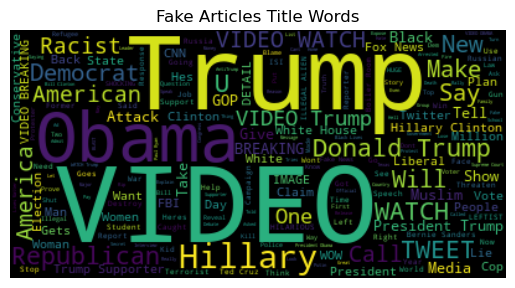

In [34]:
wordcloud_title_fake = WordCloud().generate(fake_title_words)
plt.figure()
plt.imshow(wordcloud_title_fake, interpolation="bilinear")
plt.title("Fake Articles Title Words")
plt.axis("off")
plt.show()

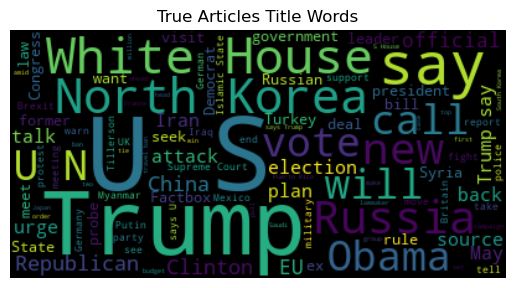

In [35]:
wordcloud_title_true = WordCloud().generate(true_title_words)
plt.figure()
plt.imshow(wordcloud_title_true, interpolation="bilinear")
plt.title("True Articles Title Words")
plt.axis("off")
plt.show()

#### Word Clouds for Text Column

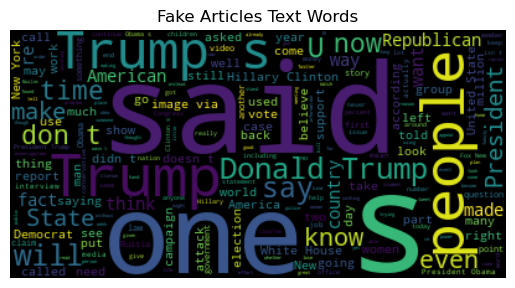

In [63]:
wordcloud_fake = WordCloud().generate(fake_words)
plt.figure()
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.title("Fake Articles Text Words")
plt.axis("off")
plt.show()

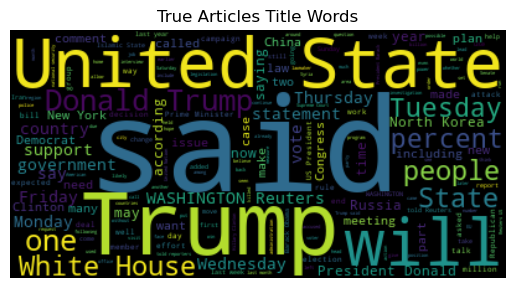

In [64]:
wordcloud_true = WordCloud().generate(true_words)
plt.figure()
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.title("True Articles Title Words")
plt.axis("off")
plt.show()

#### Comparing title and text length between fake and real news articles

In [65]:
train_df["title_length"] = train_df["title"].str.len()
train_df["text_length"] = train_df["text"].str.len()

In [66]:
title_length_hist = alt.Chart(train_df).mark_bar(opacity=0.75).encode(
    x=alt.X('title_length',
            bin=alt.Bin(maxbins=30),
            title='Title Length (Number of Words)'),
    y=alt.Y('count()', title='Number of Articles'),
    color=alt.Color('target', title='News Type')
).properties(
    title='Distribution of Article Title Lengths by News Type',
    height=300,
    width=500
)

title_length_hist

alt.Chart(...)

In [67]:
filtered_df = train_df[train_df['text_length'] < 12000]

text_length_hist = alt.Chart(filtered_df).mark_bar(opacity=0.75).encode(
    x=alt.X('text_length',
            bin=alt.Bin(maxbins=30),
            title='Text Length (Number of Words)'),
    y=alt.Y('count()', title='Number of Articles'),
    color=alt.Color('target', title='News Type')
).properties(
    title='Distribution of Article Text Lengths by News Type',
    height=300,
    width=500
)

text_length_hist

alt.Chart(...)

## Discussion

## References